v1: 0.6975752968044626

v2, add features from song_labels and save_for_later: 0.6968573037242837

v3, learning_rate=0.1: 0.6949289345303004

v4, n_estimators = 300: 0.6948962220108962 -- not much increase so chuck

v5, added score_1 features -- 0.6963200803971711 -- better on test, so use

In [95]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [63]:
data = pd.read_csv('edited_train.csv')
save_for_later = pd.read_csv('save_for_later.csv')
song_labels = pd.read_csv('song_labels.csv')

train, val = train_test_split(data, test_size=0.05, random_state=42, stratify = data['score'])
data.head()

,customer_id,song_id,score,First_Customer_id,platform_id,released_year,language,number_of_comments,First_song_id,song_avg,cust_avg
0,O29219,3459,3,O,P49540,1782.0,eng,1066.0,P,4.069767,3.029851
1,O29219,12,1,O,W13335037,2011.0,eng,101023.0,W,4.093750,3.029851
2,O29219,18,3,O,U5,1999.0,eng,36099.0,U,4.421668,3.029851
3,O29219,17,3,O,X6148028,2009.0,eng,88538.0,X,4.152371,3.029851
4,O29219,332,3,O,U65605,1953.0,eng,8690.0,U,3.863636,3.029851


In [64]:
song_labels.head()

,platform_id,label_id,count
0,Q207781,10304,6
1,S961833,29011,15
2,X6718608,25148,29
3,Q16134551,8717,774
4,V7126,15169,120


In [65]:
def merge_feature(train, df, feat_m, feat_trans, name, func, test = False):
    if func == 1:
        edited = train.groupby([feat_m]).count()
    if func == 2:
        edited = train.groupby([feat_m]).var()
    if func == 3:
        edited = train.groupby([feat_m]).std()
    if func == 4:
        edited = train.groupby([feat_m]).mean()
        
    edited = edited.reset_index()
    df = df.merge(edited[[feat_m, feat_trans]], how = 'left' , on = feat_m)
    if test == False:
        df = df.rename(columns ={feat_trans + '_x': feat_trans, feat_trans+'_y': name})
    else:
        df = df.rename(columns ={feat_trans : name})
    

    return df

In [66]:
train = merge_feature(train, train, 'customer_id', 'song_id','cust_count', 1)
val = merge_feature(train, val, 'customer_id', 'song_id','cust_count', 1)
train = merge_feature(train, train, 'customer_id', 'score','cust_var', 2)
val = merge_feature(train, val, 'customer_id', 'score','cust_var', 2)
train = merge_feature(train, train, 'customer_id', 'score','cust_std', 3)
val = merge_feature(train, val, 'customer_id', 'score','cust_std', 3)
train = merge_feature(save_for_later, train, 'customer_id', 'song_id','later_usercount', 1)
val = merge_feature(save_for_later, val, 'customer_id', 'song_id','later_usercount', 1)


train = merge_feature(train, train, 'song_id', 'customer_id','song_count', 1)
val = merge_feature(train, val, 'song_id', 'customer_id','song_count', 1)
train = merge_feature(train, train,'song_id', 'score','song_var', 2)
val = merge_feature(train, val, 'song_id', 'score','song_var', 2)
train = merge_feature(train, train,'song_id', 'score','song_std', 3)
val = merge_feature(train, val, 'song_id', 'score','song_std', 3)
train = merge_feature(save_for_later, train, 'song_id', 'customer_id','later_songcount', 1)
val = merge_feature(save_for_later, val, 'song_id', 'customer_id','later_songcount', 1)
train = merge_feature(song_labels, train, 'platform_id', 'label_id','label_count', 1, True)
val = merge_feature(song_labels, val, 'platform_id', 'label_id','label_count', 1, True)
train = merge_feature(song_labels, train, 'platform_id', 'count','label_avg', 4, True)
val = merge_feature(song_labels, val, 'platform_id', 'count','label_avg', 4, True)



train.head()

,customer_id,song_id,score,First_Customer_id,platform_id,released_year,language,number_of_comments,First_song_id,song_avg,...,cust_count,cust_var,cust_std,later_usercount,song_count,song_var,song_std,later_songcount,label_count,label_avg
0,M41967,2621,4,M,P10890,1999.0,en-CA,2197.0,P,4.109091,...,80,0.405063,0.636446,1.0,50,0.833061,0.912722,17.0,100,227.71
1,O8379,718,3,O,U10975,1929.0,eng,5485.0,U,3.706667,...,59,0.582700,0.763348,8.0,216,1.462446,1.209316,128.0,100,135.01
2,J24604,7331,4,J,P5093760,2009.0,eng,1089.0,P,3.846154,...,54,0.312020,0.558587,32.0,13,0.641026,0.800641,7.0,100,44.30
3,M1847,621,4,M,R37732,1970.0,eng,5168.0,R,3.886447,...,51,0.323137,0.568452,20.0,257,1.012828,1.006394,30.0,100,543.45
4,H4872,244,2,H,Y66559,2006.0,en-US,28268.0,Y,3.734491,...,64,0.586310,0.765709,19.0,385,0.815043,0.902797,122.0,100,721.67


In [67]:
train_ratings = train.groupby(['customer_id', 'score']).agg({'score': ['count']})
train_ratings.columns=['num_rate']
train_ratings=train_ratings.reset_index()
train_ratings["user_rate_1"] = train_ratings["num_rate"]
train_ratings.loc[train_ratings['score'] != 1, 'user_rate_1'] = 0
train_ratings=train_ratings.drop(['score'],axis=1)
train_ratings=train_ratings.drop(['num_rate'],axis=1)
edited = train_ratings.groupby(['customer_id']).sum()
train = pd.merge(train, edited, on='customer_id', how='left')
val = pd.merge(val, edited, on='customer_id', how='left')

train_ratings = train.groupby(['song_id', 'score']).agg({'score': ['count']})
train_ratings.columns=['num_rate']
train_ratings=train_ratings.reset_index()
train_ratings["song_rate_1"] = train_ratings["num_rate"]
train_ratings.loc[train_ratings['score'] != 1, 'song_rate_1'] = 0
train_ratings=train_ratings.drop(['score'],axis=1)
train_ratings=train_ratings.drop(['num_rate'],axis=1)
edited = train_ratings.groupby(['song_id']).sum()
train = pd.merge(train, edited, on='song_id', how='left')
val = pd.merge(val, edited, on='song_id', how='left')

train=train.fillna(0)
val=val.fillna(0)

train.head()

,customer_id,song_id,score,First_Customer_id,platform_id,released_year,language,number_of_comments,First_song_id,song_avg,...,cust_std,later_usercount,song_count,song_var,song_std,later_songcount,label_count,label_avg,user_rate_1,song_rate_1
0,M41967,2621,4,M,P10890,1999.0,en-CA,2197.0,P,4.109091,...,0.636446,1.0,50,0.833061,0.912722,17.0,100,227.71,1,0
1,O8379,718,3,O,U10975,1929.0,eng,5485.0,U,3.706667,...,0.763348,8.0,216,1.462446,1.209316,128.0,100,135.01,0,14
2,J24604,7331,4,J,P5093760,2009.0,eng,1089.0,P,3.846154,...,0.558587,32.0,13,0.641026,0.800641,7.0,100,44.30,0,0
3,M1847,621,4,M,R37732,1970.0,eng,5168.0,R,3.886447,...,0.568452,20.0,257,1.012828,1.006394,30.0,100,543.45,0,4
4,H4872,244,2,H,Y66559,2006.0,en-US,28268.0,Y,3.734491,...,0.765709,19.0,385,0.815043,0.902797,122.0,100,721.67,0,4


In [68]:
train.shape

(673731, 23)

In [69]:
Y_train = train.score
# X_train = train.drop(['score','customer_id', 'song_id', 'platform_id' ,'language'], axis =1)
# X_test = val.drop(['score','customer_id', 'song_id', 'platform_id','language'], axis =1)
X_train = train[['released_year','number_of_comments','song_avg', 'cust_avg', 'cust_count'
                ,'cust_var', 'cust_std', 'song_count', 'song_var', 'song_std', 'later_usercount'
                ,'later_songcount', 'label_count', 'label_avg', 'user_rate_1', 'song_rate_1']]
X_test = val[['released_year','number_of_comments','song_avg', 'cust_avg', 'cust_count'
                ,'cust_var', 'cust_std', 'song_count', 'song_var', 'song_std', 'later_usercount'
                ,'later_songcount', 'label_count', 'label_avg','user_rate_1', 'song_rate_1']]

# cat_attribs = ['First_Customer_id', 'First_song_id']
# full_pipeline = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cat_attribs)], remainder='passthrough')

# encoder = full_pipeline.fit(X_train)
# X_train = encoder.transform(X_train)
# X_test = encoder.transform(X_test)

In [72]:
model =  xgb.XGBRegressor(learning_rate = 0.1, verbosity = 1)
model.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)

In [80]:
preds = model.predict(X_test)
Y_test = val.score

In [81]:
Y_test.unique()

array([4, 5, 3, 2, 1])

In [82]:
PRED = np.around(preds,1)

PRED = np.clip(PRED, a_min# SUBMISSION
 = 1, a_max = 5)

In [83]:
mean_squared_error(Y_test, PRED)

0.6963200803971711

In [30]:
mean_squared_error(Y_test, PRED)

0.6949289345303004

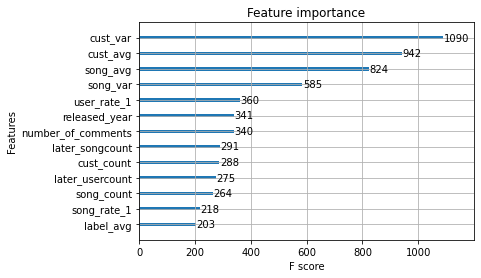

In [84]:
xgb.plot_importance(model)
plt.show()

In [85]:
train = pd.read_csv('edited_train.csv')
val = pd.read_csv('edited_test.csv') 
test = pd.read_csv('test.csv')


print(val.shape,train.shape)

(670681, 10) (709191, 11)


In [86]:
train = merge_feature(train, train, 'customer_id', 'song_id','cust_count', 1)
val = merge_feature(train, val, 'customer_id', 'song_id','cust_count', 1)
train = merge_feature(train, train, 'customer_id', 'score','cust_var', 2)
val = merge_feature(train, val, 'customer_id', 'score','cust_var', 2, True)
train = merge_feature(train, train, 'customer_id', 'score','cust_std', 3)
val = merge_feature(train, val, 'customer_id', 'score','cust_std', 3, True)
train = merge_feature(save_for_later, train, 'customer_id', 'song_id','later_usercount', 1)
val = merge_feature(save_for_later, val, 'customer_id', 'song_id','later_usercount', 1)



train = merge_feature(train, train, 'song_id', 'customer_id','song_count', 1)
val = merge_feature(train, val, 'song_id', 'customer_id','song_count', 1)
train = merge_feature(train, train,'song_id', 'score','song_var', 2)
val = merge_feature(train, val, 'song_id', 'score','song_var', 2, True)
train = merge_feature(train, train,'song_id', 'score','song_std', 3)
val = merge_feature(train, val, 'song_id', 'score','song_std', 3, True)
train = merge_feature(save_for_later, train, 'song_id', 'customer_id','later_songcount', 1)
val = merge_feature(save_for_later, val, 'song_id', 'customer_id','later_songcount', 1)
train = merge_feature(song_labels, train, 'platform_id', 'label_id','label_count', 1, True)
val = merge_feature(song_labels, val, 'platform_id', 'label_id','label_count', 1, True)
train = merge_feature(song_labels, train, 'platform_id', 'count','label_avg', 4, True)
val = merge_feature(song_labels, val, 'platform_id', 'count','label_avg', 4, True)


val.head()

,customer_id,song_id,First_Customer_id,platform_id,released_year,language,number_of_comments,First_song_id,song_avg,cust_avg,cust_count,cust_var,cust_std,later_usercount,song_count,song_var,song_std,later_songcount,label_count,label_avg
0,J24644,5304.0,J,U64955,1989.0,NaN,416.0,U,3.468085,3.566667,60,0.859887,0.927301,17.0,47.0,0.689177,0.830167,2.0,100.0,49.11
1,J24644,1423.0,J,Y10619,1995.0,eng,1714.0,Y,3.428571,3.566667,60,0.859887,0.927301,17.0,126.0,1.014857,1.007401,18.0,100.0,325.16
2,J24644,670.0,J,S11573,1979.0,en-US,2294.0,S,3.843137,3.566667,60,0.859887,0.927301,17.0,255.0,0.676085,0.822244,25.0,100.0,85.45
3,J24644,4465.0,J,V653396,1987.0,en-US,672.0,V,3.692308,3.566667,60,0.859887,0.927301,17.0,39.0,1.218623,1.103913,24.0,100.0,56.93
4,J24644,5.0,J,Q4671,1925.0,eng,51992.0,Q,3.846195,3.566667,60,0.859887,0.927301,17.0,1879.0,1.049281,1.024344,394.0,100.0,1344.29


In [87]:
train_ratings = train.groupby(['customer_id', 'score']).agg({'score': ['count']})
train_ratings.columns=['num_rate']
train_ratings=train_ratings.reset_index()
train_ratings["user_rate_1"] = train_ratings["num_rate"]
train_ratings.loc[train_ratings['score'] != 1, 'user_rate_1'] = 0
train_ratings=train_ratings.drop(['score'],axis=1)
train_ratings=train_ratings.drop(['num_rate'],axis=1)
edited = train_ratings.groupby(['customer_id']).sum()
train = pd.merge(train, edited, on='customer_id', how='left')
val = pd.merge(val, edited, on='customer_id', how='left')

train_ratings = train.groupby(['song_id', 'score']).agg({'score': ['count']})
train_ratings.columns=['num_rate']
train_ratings=train_ratings.reset_index()
train_ratings["song_rate_1"] = train_ratings["num_rate"]
train_ratings.loc[train_ratings['score'] != 1, 'song_rate_1'] = 0
train_ratings=train_ratings.drop(['score'],axis=1)
train_ratings=train_ratings.drop(['num_rate'],axis=1)
edited = train_ratings.groupby(['song_id']).sum()
train = pd.merge(train, edited, on='song_id', how='left')
val = pd.merge(val, edited, on='song_id', how='left')

train=train.fillna(0)
val=val.fillna(0)

train.head()

,customer_id,song_id,score,First_Customer_id,platform_id,released_year,language,number_of_comments,First_song_id,song_avg,...,cust_std,later_usercount,song_count,song_var,song_std,later_songcount,label_count,label_avg,user_rate_1,song_rate_1
0,O29219,3459,3,O,P49540,1782.0,eng,1066.0,P,4.069767,...,0.737936,0.0,43,0.875969,0.935932,29.0,100,393.62,2,1
1,O29219,12,1,O,W13335037,2011.0,eng,101023.0,W,4.093750,...,0.737936,0.0,1472,0.842327,0.917784,303.0,100,1968.25,2,14
2,O29219,18,3,O,U5,1999.0,eng,36099.0,U,4.421668,...,0.737936,0.0,1883,0.585120,0.764931,132.0,100,2272.15,2,8
3,O29219,17,3,O,X6148028,2009.0,eng,88538.0,X,4.152371,...,0.737936,0.0,1982,0.734974,0.857306,161.0,100,1175.77,2,12
4,O29219,332,3,O,U65605,1953.0,eng,8690.0,U,3.863636,...,0.737936,0.0,396,0.913003,0.955512,53.0,100,170.55,2,6


In [88]:
Y_train = train.score
# X_train = train.drop(['score','customer_id', 'song_id', 'platform_id' ,'language'], axis =1)
# X_test = val.drop(['score','customer_id', 'song_id', 'platform_id','language'], axis =1)
X_train = train[['released_year','number_of_comments','song_avg', 'cust_avg', 'cust_count'
                ,'cust_var', 'cust_std', 'song_count', 'song_var', 'song_std', 'later_usercount'
                ,'later_songcount', 'label_count', 'label_avg', 'user_rate_1', 'song_rate_1']]
X_test = val[['released_year','number_of_comments','song_avg', 'cust_avg', 'cust_count'
                ,'cust_var', 'cust_std', 'song_count', 'song_var', 'song_std', 'later_usercount'
                ,'later_songcount', 'label_count', 'label_avg','user_rate_1', 'song_rate_1']]


model =  xgb.XGBRegressor(learning_rate = 0.1)
model.fit(X_train, Y_train)

preds = model.predict(X_test)
PRED = np.around(preds,1)

PRED = np.clip(PRED, a_min# SUBMISSION
 = 1, a_max = 5)

In [89]:
val['preds'] = PRED

In [90]:
test = test.merge(val[['customer_id','song_id','preds']], how = 'left', on = ['customer_id', 'song_id'])
test.head()

,customer_id,song_id,preds
0,J24644,5304,3.2
1,G29701,123,3.6
2,M29977,11,4.4
3,H50752,1445,3.8
4,J42394,271,4.5


In [91]:
PRED = test.preds
df_submission = pd.read_csv('dummy_submission.csv')
df_submission.score = PRED
df_submission.to_csv('./RF_v5.csv',index=False)

In [92]:
PRED.size

670681

In [93]:
pred1 = pd.read_csv('RF_v5.csv')
pred2 = pd.read_csv('RM_v4.csv')

pred1['score']  = 0.5*(pred1['score'] + pred2['score'])
pred1.head()

,test_row_id,score
0,0,3.30
1,1,3.80
2,2,4.20
3,3,3.85
4,4,4.30


In [94]:
pred1.to_csv('RM_RF_v45', index = False)